# 3EMA + MACD-V + Aroon Ensemble Strategy Notebook

## Data Split Information

**Training Period (In-Sample)**: Used for evaluating strategy performance  
**Validation Period (Out-of-Sample)**: Used for out-of-sample validation

**Split Ratio**: 70% training, 30% validation

This notebook evaluates a **Triple EMA + MACD-V + Aroon ensemble strategy** using hardcoded best parameters with OR logic.

## Strategy Components

**Triple EMA (3EMA)**: Trend-following signals  
**MACD-V**: Volume-confirmed signals  
**Aroon**: Trend strength signals  

**Logic**: Entries/exits triggered when ANY of the three indicators provides a signal (OR logic)


In [1]:
# !pip install yfinance
# !pip install TA-Lib
# !pip install numpy
# !pip install pandas
# !pip install vectorbt
# !pip install scipy
# %pip install scikit-optimize
# %pip install optuna


In [2]:
import yfinance as yf
import talib
import numpy as np
import pandas as pd
import vectorbt as vbt
import warnings
from scipy import stats
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", message="Degrees of freedom <= 0 for slice", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="invalid value encountered in scalar divide", category=RuntimeWarning)


In [3]:
# DOWNLOAD STOCK DATA FROM 2015 USING YFINANCE

TICKER = 'GLD'
START_DATE = '2018-01-01'
TRAIN_RATIO = 0.6

# Download data
stock_data = yf.download(TICKER, start=START_DATE, interval='1d')

if not stock_data.empty:
    print(f"Successfully downloaded {len(stock_data)} records for {TICKER}")
    print(f"Data range: {stock_data.index.min().date()} to {stock_data.index.max().date()}")
else:
    print(f"Failed to download {TICKER} data")

stock_data

C:\Users\harka\AppData\Local\Temp\ipykernel_3380\4155757813.py:8: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

Successfully downloaded 1998 records for GLD
Data range: 2018-01-02 to 2025-12-11


Price,Close,High,Low,Open,Volume
Ticker,GLD,GLD,GLD,GLD,GLD
Date,,,,,
2018-01-02,125.150002,125.180000,124.389999,124.660004,11762500
2018-01-03,124.820000,125.089996,124.099998,125.050003,7904300
2018-01-04,125.459999,125.849998,124.739998,124.889999,7329700
2018-01-05,125.330002,125.480003,124.830002,124.930000,5739900
2018-01-08,125.309998,125.320000,124.900002,125.199997,3566700
...,...,...,...,...,...
2025-12-05,386.440002,391.739990,386.179993,389.119995,9449800
2025-12-08,385.420013,387.239990,384.010010,387.019989,6822100


In [4]:
# PREPARE PRICE SERIES

def select_close_series(df, ticker):
    if isinstance(df.columns, pd.MultiIndex):
        if ('Close', ticker) in df.columns:
            s = df[('Close', ticker)]
        else:
            cols = [c for c in df.columns if 'Close' in str(c)]
            if not cols:
                raise KeyError("Close not found")
            s = df[cols[0]]
    else:
        s = df['Close']
    return s.astype(float).squeeze()

close = select_close_series(stock_data, TICKER)
close.name = 'price'

# Simple split
split_idx = int(len(close) * TRAIN_RATIO)
train_close = close.iloc[:split_idx].copy()
val_close = close.iloc[split_idx:].copy()

print("=" * 70)
print("DATA SPLIT INFORMATION")
print("=" * 70)
print(f"Training Period (In-Sample):   {train_close.index[0].date()} to {train_close.index[-1].date()}")
print(f"  Duration: {len(train_close)} days (~{len(train_close)/252:.1f} years)")
print(f"")
print(f"Validation Period (Out-of-Sample): {val_close.index[0].date()} to {val_close.index[-1].date()}")
print(f"  Duration: {len(val_close)} days (~{len(val_close)/252:.1f} years)")
print(f"")
print(f"Split Ratio: {len(train_close)/len(close)*100:.0f}% / {len(val_close)/len(close)*100:.0f}%")
print("=" * 70)


DATA SPLIT INFORMATION
Training Period (In-Sample):   2018-01-02 to 2022-10-04
  Duration: 1198 days (~4.8 years)

Validation Period (Out-of-Sample): 2022-10-05 to 2025-12-11
  Duration: 800 days (~3.2 years)

Split Ratio: 60% / 40%


In [5]:
# HARDCODED STRATEGY PARAMETERS (Best from Previous Optimizations)

# Triple EMA parameters
ema1 = 10
ema2 = 161
ema3 = 121

# MACD-V parameters
macd_fast = 48
macd_slow = 59
macd_signal = 50
volume_threshold = 0.0

# Aroon parameters
aroon_length = 156

print("=" * 70)
print("HARDCODED ENSEMBLE STRATEGY PARAMETERS")
print("=" * 70)
print(f"Triple EMA:")
print(f"  EMA1 (Fast):   {ema1}")
print(f"  EMA2 (Medium):   {ema2}")
print(f"  EMA3 (Slow):     {ema3}")
print(f"")
print(f"MACD-V:")
print(f"  MACD Fast:       {macd_fast}")
print(f"  MACD Slow:       {macd_slow}")
print(f"  MACD Signal:     {macd_signal}")
print(f"  Volume Threshold: {volume_threshold}")
print(f"")
print(f"Aroon:")
print(f"  Aroon Length:    {aroon_length}")
print("=" * 70)
print(f"\nStrategy Logic: 3EMA OR MACD-V OR Aroon (any indicator triggers signal)")
print("=" * 70)


HARDCODED ENSEMBLE STRATEGY PARAMETERS
Triple EMA:
  EMA1 (Fast):   10
  EMA2 (Medium):   161
  EMA3 (Slow):     121

MACD-V:
  MACD Fast:       48
  MACD Slow:       59
  MACD Signal:     50
  Volume Threshold: 0.0

Aroon:
  Aroon Length:    156

Strategy Logic: 3EMA OR MACD-V OR Aroon (any indicator triggers signal)


In [6]:
# ENSEMBLE STRATEGY EVALUATION FUNCTION

def evaluate_ensemble_strategy(data, stock_data_for_volume, return_metrics=False):
    """
    Evaluate 3EMA + MACD-V + Aroon ensemble strategy with OR logic.
    
    Args:
        data: price data to test on
        stock_data_for_volume: full stock data with volume column
        return_metrics: if True, return full metrics dict; if False, return negative Sortino ratio
    
    Returns:
        Negative Sortino ratio (for minimization) or full metrics dict
    """
    
    try:
        # Calculate EMAs
        ema1_ma = vbt.MA.run(data, ema1, ewm=True).ma
        ema2_ma = vbt.MA.run(data, ema2, ewm=True).ma
        ema3_ma = vbt.MA.run(data, ema3, ewm=True).ma
        
        # 3EMA Signals
        entries_3ema = (
            ema1_ma.vbt.crossed_above(ema2_ma) |
            ema1_ma.vbt.crossed_above(ema3_ma) |
            ema2_ma.vbt.crossed_above(ema3_ma)
        )
        exits_3ema = (
            ema1_ma.vbt.crossed_below(ema2_ma) |
            ema1_ma.vbt.crossed_below(ema3_ma) |
            ema2_ma.vbt.crossed_below(ema3_ma)
        )
        
        # MACD-V Signals
        close_array = data.values
        macd, macd_signal_line, _ = talib.MACD(close_array, fastperiod=macd_fast, slowperiod=macd_slow, signalperiod=macd_signal)
        macd_series = pd.Series(macd, index=data.index)
        signal_series = pd.Series(macd_signal_line, index=data.index)
        
        # Get volume
        if isinstance(stock_data_for_volume.columns, pd.MultiIndex):
            volume_data = stock_data_for_volume[('Volume', TICKER)]
        else:
            volume_data = stock_data_for_volume['Volume']
        
        volume_aligned = volume_data.reindex(data.index)
        volume_sma = volume_aligned.rolling(window=20).mean()
        volume_ratio = volume_aligned / volume_sma
        
        # MACD-V entries: MACD crosses above signal AND volume > threshold
        macd_bullish_cross = (macd_series > signal_series) & (macd_series.shift(1) <= signal_series.shift(1))
        volume_confirm = volume_ratio > volume_threshold
        entries_macdv = pd.Series(macd_bullish_cross & volume_confirm, index=data.index).fillna(False)
        
        # MACD-V exits: MACD crosses below signal AND volume > threshold
        macd_bearish_cross = (macd_series < signal_series) & (macd_series.shift(1) >= signal_series.shift(1))
        exits_macdv = pd.Series(macd_bearish_cross & volume_confirm, index=data.index).fillna(False)
        
        # Aroon Signals
        aroon_up, aroon_down = talib.AROON(close_array, close_array, timeperiod=aroon_length)
        aroon_up_series = pd.Series(aroon_up, index=data.index)
        aroon_down_series = pd.Series(aroon_down, index=data.index)
        
        entries_aroon = aroon_up_series.vbt.crossed_above(aroon_down_series)
        exits_aroon = aroon_up_series.vbt.crossed_below(aroon_down_series)
        
        # Combine with OR logic
        entries_final = entries_3ema | entries_macdv | entries_aroon
        exits_final = exits_3ema | exits_macdv | exits_aroon
        
        # Convert to arrays
        entries_array = pd.Series(np.asarray(entries_final).ravel(), index=data.index, dtype=bool)
        exits_array = pd.Series(np.asarray(exits_final).ravel(), index=data.index, dtype=bool)
        
        # Backtest
        portfolio = vbt.Portfolio.from_signals(
            close=data,
            entries=entries_array,
            exits=exits_array,
            init_cash=100_000,
            fees=0.0005,
            slippage=0.0005,
            freq='D'
        )
        
        # Calculate key metrics
        sharpe_ratio = float(portfolio.sharpe_ratio(freq='D'))
        sortino_ratio = float(portfolio.sortino_ratio(freq='D'))
        total_return = float(portfolio.total_return())
        max_drawdown = float(portfolio.max_drawdown())
        volatility = float(portfolio.annualized_volatility(freq='D'))
        
        # Trade metrics
        trades = portfolio.trades
        total_trades = len(trades)
        
        # Check for sufficient trading activity
        years = max((data.index[-1] - data.index[0]).days / 365.25, 1e-9)
        trades_per_year = total_trades / years
        
        if trades_per_year < 1:
            if return_metrics:
                return {
                    'ema1': ema1, 'ema2': ema2, 'ema3': ema3,
                    'macd_fast': macd_fast, 'macd_slow': macd_slow, 'macd_signal': macd_signal,
                    'aroon_length': aroon_length,
                    'sharpe_ratio': np.nan,
                    'sortino_ratio': np.nan,
                    'total_return': np.nan,
                    'annualized_return': np.nan,
                    'max_drawdown': np.nan,
                    'volatility': np.nan,
                    'total_trades': total_trades,
                    'win_rate': np.nan,
                    'profit_factor': np.nan,
                    'expectancy': np.nan,
                    'trades_per_year': trades_per_year
                }
            return 999.0
        
        if return_metrics:
            # Calculate additional metrics
            win_rate_pct = np.nan
            profit_factor = np.nan
            expectancy = 0.0
            annualized_return = (1.0 + total_return) ** (1.0 / years) - 1.0 if years > 0 else np.nan
            
            if total_trades > 0:
                tr = trades.returns.values if hasattr(trades.returns, 'values') else np.array(trades.returns)
                if tr.size > 0:
                    pos = tr[tr > 0]
                    neg = tr[tr < 0]
                    win_rate_pct = (len(pos) / len(tr)) * 100.0
                    gains = pos.sum() if len(pos) else 0.0
                    losses = abs(neg.sum()) if len(neg) else 0.0
                    profit_factor = (gains / losses) if losses > 0 else np.inf
                    expectancy = float(tr.mean())
            
            return {
                'ema1': ema1, 'ema2': ema2, 'ema3': ema3,
                'macd_fast': macd_fast, 'macd_slow': macd_slow, 'macd_signal': macd_signal,
                'aroon_length': aroon_length,
                'sharpe_ratio': sharpe_ratio,
                'sortino_ratio': sortino_ratio,
                'total_return': total_return,
                'annualized_return': annualized_return,
                'max_drawdown': max_drawdown,
                'volatility': volatility,
                'total_trades': total_trades,
                'win_rate': win_rate_pct,
                'profit_factor': profit_factor,
                'expectancy': expectancy,
                'trades_per_year': trades_per_year
            }
        else:
            return -sortino_ratio
            
    except Exception as e:
        return 999.0

print("✅ Ensemble strategy evaluation function created!")
print("Function combines 3EMA + MACD-V + Aroon with OR logic.")


✅ Ensemble strategy evaluation function created!
Function combines 3EMA + MACD-V + Aroon with OR logic.


In [7]:
# EVALUATE ENSEMBLE STRATEGY ON TRAINING DATA

train_result = evaluate_ensemble_strategy(
    data=train_close,
    stock_data_for_volume=stock_data.iloc[:split_idx],
    return_metrics=True
)

# Create results dataframe  
results_df = pd.DataFrame([train_result])

print("\n✅ Ensemble Strategy Evaluation Complete!")
print(f"Total Return: {train_result['total_return']:.2%}")
print(f"Sharpe Ratio: {train_result['sharpe_ratio']:.3f}")
print(f"Sortino Ratio: {train_result['sortino_ratio']:.3f}")
print(f"Total Trades: {int(train_result['total_trades'])}")



✅ Ensemble Strategy Evaluation Complete!
Total Return: 34.52%
Sharpe Ratio: 0.796
Sortino Ratio: 1.111
Total Trades: 14


In [8]:
# DISPLAY RESULTS

if 'results_df' in globals() and not results_df.empty:
    best = results_df.iloc[0]
    
    print("=" * 70)
    print("ENSEMBLE STRATEGY EVALUATION RESULTS")
    print("=" * 70)
    print(f"\nStrategy Parameters:")
    print(f"  EMA1: {int(best['ema1'])}, EMA2: {int(best['ema2'])}, EMA3: {int(best['ema3'])}")
    print(f"  MACD: Fast={int(best['macd_fast'])}, Slow={int(best['macd_slow'])}, Signal={int(best['macd_signal'])}")
    print(f"  Aroon Length: {int(best['aroon_length'])}")
    
    print(f"\n📊 Performance Metrics (Training Set):")
    print(f"  Total Return:      {best['total_return']:.2%}")
    print(f"  Annualized Return: {best['annualized_return']:.2%}")
    print(f"  Sharpe Ratio:      {best['sharpe_ratio']:.3f}")
    print(f"  Sortino Ratio:     {best['sortino_ratio']:.3f}")
    print(f"  Max Drawdown:      {best['max_drawdown']:.2%}")
    print(f"  Volatility:        {best['volatility']:.2%}")
    print(f"  Total Trades:     {int(best['total_trades'])}")
    print(f"  Win Rate:          {best['win_rate']:.1f}%")
    print(f"  Profit Factor:     {best['profit_factor']:.2f}")
    print(f"  Trades per Year:   {best['trades_per_year']:.1f}")
    print("=" * 70)
else:
    print("⚠️ No results available.")


ENSEMBLE STRATEGY EVALUATION RESULTS

Strategy Parameters:
  EMA1: 10, EMA2: 161, EMA3: 121
  MACD: Fast=48, Slow=59, Signal=50
  Aroon Length: 156

📊 Performance Metrics (Training Set):
  Total Return:      34.52%
  Annualized Return: 6.44%
  Sharpe Ratio:      0.796
  Sortino Ratio:     1.111
  Max Drawdown:      -13.24%
  Volatility:        12.31%
  Total Trades:     14
  Win Rate:          50.0%
  Profit Factor:     3.30
  Trades per Year:   2.9


In [9]:
# EVALUATE ON VALIDATION SET

val_result = evaluate_ensemble_strategy(
    data=val_close,
    stock_data_for_volume=stock_data.iloc[split_idx:],
    return_metrics=True
)

print("\n📊 Performance Metrics (Validation Set):")
print(f"  Total Return:      {val_result['total_return']:.2%}")
print(f"  Annualized Return: {val_result['annualized_return']:.2%}")
print(f"  Sharpe Ratio:      {val_result['sharpe_ratio']:.3f}")
print(f"  Sortino Ratio:     {val_result['sortino_ratio']:.3f}")
print(f"  Max Drawdown:      {val_result['max_drawdown']:.2%}")
print(f"  Total Trades:      {int(val_result['total_trades'])}")
print(f"  Win Rate:          {val_result['win_rate']:.1f}%")
print(f"  Profit Factor:     {val_result['profit_factor']:.2f}")

# Calculate degradation
def chg(before, after):
    if pd.isna(before) or pd.isna(after) or before == 0:
        return "N/A"
    return f"{((after - before) / abs(before)) * 100:+.1f}%"

print("\n" + "=" * 70)
print("IN-SAMPLE vs OUT-OF-SAMPLE COMPARISON")
print("=" * 70)
print(f"{'METRIC':<25} {'IN-SAMPLE':<15} {'OUT-OF-SAMPLE':<15} {'CHANGE':<15}")

print("\nRETURN METRICS:")
print(f"{'Total Return':<25} {train_result['total_return']:<15.2%} {val_result['total_return']:<15.2%} {chg(train_result['total_return'], val_result['total_return'])}")
print(f"{'Annualized Return':<25} {train_result['annualized_return']:<15.2%} {val_result['annualized_return']:<15.2%} {chg(train_result['annualized_return'], val_result['annualized_return'])}")

print("\nRISK-ADJUSTED METRICS:")
print(f"{'Sharpe Ratio':<25} {train_result['sharpe_ratio']:<15.3f} {val_result['sharpe_ratio']:<15.3f} {chg(train_result['sharpe_ratio'], val_result['sharpe_ratio'])}")
print(f"{'Sortino Ratio':<25} {train_result['sortino_ratio']:<15.3f} {val_result['sortino_ratio']:<15.3f} {chg(train_result['sortino_ratio'], val_result['sortino_ratio'])}")

print("\nTRADE METRICS:")
print(f"{'Total Trades':<25} {train_result['total_trades']:<15.0f} {val_result['total_trades']:<15.0f} {chg(train_result['total_trades'], val_result['total_trades'])}")
print(f"{'Win Rate %':<25} {train_result['win_rate']:<15.1f} {val_result['win_rate']:<15.1f} {chg(train_result['win_rate'], val_result['win_rate'])}")
print(f"{'Profit Factor':<25} {train_result['profit_factor']:<15.2f} {val_result['profit_factor']:<15.2f} {chg(train_result['profit_factor'], val_result['profit_factor'])}")



📊 Performance Metrics (Validation Set):
  Total Return:      45.17%
  Annualized Return: 12.42%
  Sharpe Ratio:      1.247
  Sortino Ratio:     1.855
  Max Drawdown:      -11.94%
  Total Trades:      9
  Win Rate:          55.6%
  Profit Factor:     5.20

IN-SAMPLE vs OUT-OF-SAMPLE COMPARISON
METRIC                    IN-SAMPLE       OUT-OF-SAMPLE   CHANGE         

RETURN METRICS:
Total Return              34.52%          45.17%          +30.9%
Annualized Return         6.44%           12.42%          +92.9%

RISK-ADJUSTED METRICS:
Sharpe Ratio              0.796           1.247           +56.7%
Sortino Ratio             1.111           1.855           +67.0%

TRADE METRICS:
Total Trades              14              9               -35.7%
Win Rate %                50.0            55.6            +11.1%
Profit Factor             3.30            5.20            +57.6%


# COMPREHENSIVE VISUALIZATION AND ANALYSIS

Creating comprehensive visualizations for both training and validation periods.


In [10]:
# RECOMPUTE STRATEGY FOR FULL DATA VISUALIZATION

def get_ensemble_portfolio(data, stock_data_for_volume):
    """Run ensemble strategy and return portfolio object."""
    
    # Calculate EMAs
    ema1_ma = vbt.MA.run(data, ema1, ewm=True).ma
    ema2_ma = vbt.MA.run(data, ema2, ewm=True).ma
    ema3_ma = vbt.MA.run(data, ema3, ewm=True).ma
    
    # 3EMA Signals
    entries_3ema = (
        ema1_ma.vbt.crossed_above(ema2_ma) |
        ema1_ma.vbt.crossed_above(ema3_ma) |
        ema2_ma.vbt.crossed_above(ema3_ma)
    )
    exits_3ema = (
        ema1_ma.vbt.crossed_below(ema2_ma) |
        ema1_ma.vbt.crossed_below(ema3_ma) |
        ema2_ma.vbt.crossed_below(ema3_ma)
    )
    
    # MACD-V Signals
    close_array = data.values
    macd, macd_signal_line, _ = talib.MACD(close_array, fastperiod=macd_fast, slowperiod=macd_slow, signalperiod=macd_signal)
    macd_series = pd.Series(macd, index=data.index)
    signal_series = pd.Series(macd_signal_line, index=data.index)
    
    # Get volume
    if isinstance(stock_data_for_volume.columns, pd.MultiIndex):
        volume_data = stock_data_for_volume[('Volume', TICKER)]
    else:
        volume_data = stock_data_for_volume['Volume']
    
    volume_aligned = volume_data.reindex(data.index)
    volume_sma = volume_aligned.rolling(window=20).mean()
    volume_ratio = volume_aligned / volume_sma
    
    # MACD-V entries
    macd_bullish_cross = (macd_series > signal_series) & (macd_series.shift(1) <= signal_series.shift(1))
    volume_confirm = volume_ratio > volume_threshold
    entries_macdv = pd.Series(macd_bullish_cross & volume_confirm, index=data.index).fillna(False)
    
    # MACD-V exits
    macd_bearish_cross = (macd_series < signal_series) & (macd_series.shift(1) >= signal_series.shift(1))
    exits_macdv = pd.Series(macd_bearish_cross & volume_confirm, index=data.index).fillna(False)
    
    # Aroon Signals
    aroon_up, aroon_down = talib.AROON(close_array, close_array, timeperiod=aroon_length)
    aroon_up_series = pd.Series(aroon_up, index=data.index)
    aroon_down_series = pd.Series(aroon_down, index=data.index)
    
    entries_aroon = aroon_up_series.vbt.crossed_above(aroon_down_series)
    exits_aroon = aroon_up_series.vbt.crossed_below(aroon_down_series)
    
    # Combine with OR logic
    entries_final = entries_3ema | entries_macdv | entries_aroon
    exits_final = exits_3ema | exits_macdv | exits_aroon
    
    # Convert to arrays
    entries_array = pd.Series(np.asarray(entries_final).ravel(), index=data.index, dtype=bool)
    exits_array = pd.Series(np.asarray(exits_final).ravel(), index=data.index, dtype=bool)
    
    # Backtest
    portfolio = vbt.Portfolio.from_signals(
        close=data,
        entries=entries_array,
        exits=exits_array,
        init_cash=100_000,
        fees=0.0005,
        slippage=0.0005,
        freq='D'
    )
    
    return portfolio

# Run for both periods
print("Computing portfolios for visualization...")
train_portfolio = get_ensemble_portfolio(train_close, stock_data.iloc[:split_idx])
val_portfolio = get_ensemble_portfolio(val_close, stock_data.iloc[split_idx:])

print("✅ Portfolio computation complete!")


Computing portfolios for visualization...
✅ Portfolio computation complete!


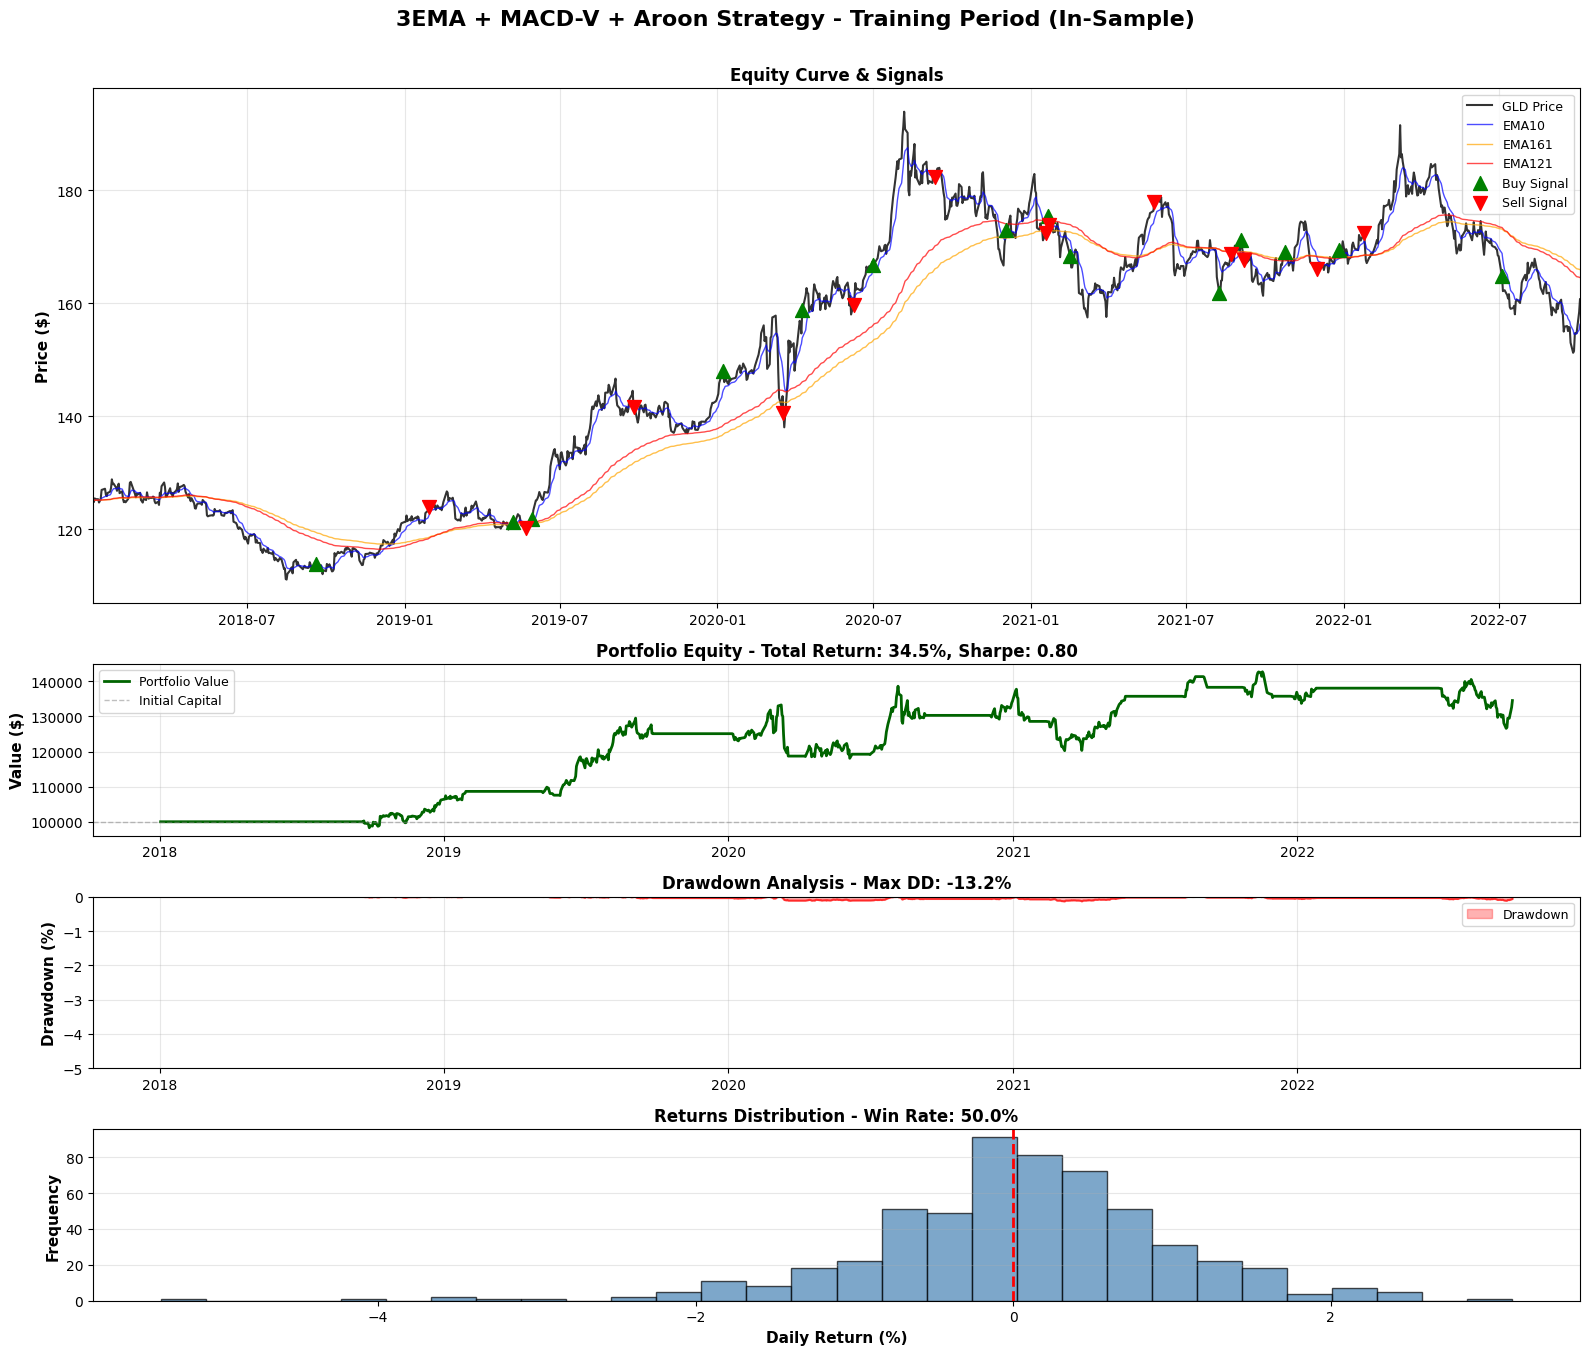

✅ Training period visualization saved!


In [11]:
# CREATE COMPREHENSIVE MULTI-PANEL VISUALIZATION - TRAINING PERIOD

fig, axes = plt.subplots(4, 1, figsize=(16, 14), height_ratios=[3, 1, 1, 1])
fig.suptitle('3EMA + MACD-V + Aroon Strategy - Training Period (In-Sample)', 
             fontsize=16, fontweight='bold', y=0.995)

# Plot 1: Price + EMAs + Signals
ax1 = axes[0]
ax1.plot(train_close.index, train_close.values, label=f'{TICKER} Price', 
         color='black', linewidth=1.5, alpha=0.8)

# Calculate EMAs for display
ema1_display = train_close.ewm(span=ema1, adjust=False).mean()
ema2_display = train_close.ewm(span=ema2, adjust=False).mean()
ema3_display = train_close.ewm(span=ema3, adjust=False).mean()

ax1.plot(train_close.index, ema1_display.values, label=f'EMA{ema1}', 
         color='blue', linewidth=1, alpha=0.7)
ax1.plot(train_close.index, ema2_display.values, label=f'EMA{ema2}', 
         color='orange', linewidth=1, alpha=0.7)
ax1.plot(train_close.index, ema3_display.values, label=f'EMA{ema3}', 
         color='red', linewidth=1, alpha=0.7)

# Plot entry/exit signals
try:
    orders_df = train_portfolio.orders.records_readable
    entries = orders_df[orders_df['Side'] == 'Buy']
    exits = orders_df[orders_df['Side'] == 'Sell']
    
    if len(entries) > 0:
        # Try different possible column names
        price_col = 'Price' if 'Price' in entries.columns else 'Amount' if 'Amount' in entries.columns else 'Value'
        time_col = 'Index' if 'Index' in entries.columns else 'Timestamp'
        
        if price_col in entries.columns and time_col in entries.columns:
            ax1.scatter(entries[time_col], entries[price_col], color='green', 
                        marker='^', s=100, label='Buy Signal', zorder=5)
    if len(exits) > 0:
        price_col = 'Price' if 'Price' in exits.columns else 'Amount' if 'Amount' in exits.columns else 'Value'
        time_col = 'Index' if 'Index' in exits.columns else 'Timestamp'
        
        if price_col in exits.columns and time_col in exits.columns:
            ax1.scatter(exits[time_col], exits[price_col], color='red', 
                        marker='v', s=100, label='Sell Signal', zorder=5)
except Exception as e:
    print(f"Could not plot signals: {e}")
    # Plot signals using trades data instead
    trades = train_portfolio.trades.records_readable
    buy_times = []
    sell_times = []
    buy_prices = []
    sell_prices = []
    
    for _, trade in trades.iterrows():
        if trade['EntryTimestamp']:
            buy_times.append(trade['EntryTimestamp'])
            buy_prices.append(trade['EntryPrice'])
        if trade['ExitTimestamp']:
            sell_times.append(trade['ExitTimestamp'])
            sell_prices.append(trade['ExitPrice'])
    
    if buy_times:
        ax1.scatter(buy_times, buy_prices, color='green', marker='^', s=100, label='Buy Signal', zorder=5)
    if sell_times:
        ax1.scatter(sell_times, sell_prices, color='red', marker='v', s=100, label='Sell Signal', zorder=5)

ax1.set_ylabel('Price ($)', fontsize=11, fontweight='bold')
ax1.set_title(f'Equity Curve & Signals', fontsize=12, fontweight='bold')
ax1.legend(loc='best', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(train_close.index[0], train_close.index[-1])

# Plot 2: Portfolio Value
ax2 = axes[1]
portfolio_value = train_portfolio.value()
ax2.plot(train_close.index, portfolio_value, label='Portfolio Value', 
         color='darkgreen', linewidth=2)
ax2.axhline(y=100000, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Initial Capital')
ax2.set_ylabel('Value ($)', fontsize=11, fontweight='bold')
ax2.set_title(f'Portfolio Equity - Total Return: {train_result["total_return"]:.1%}, '
               f'Sharpe: {train_result["sharpe_ratio"]:.2f}', fontsize=12, fontweight='bold')
ax2.legend(loc='best', fontsize=9)
ax2.grid(True, alpha=0.3)

# Plot 3: Drawdown
ax3 = axes[2]
drawdown = train_portfolio.drawdown()
ax3.fill_between(train_close.index, drawdown.values, 0, 
                  color='red', alpha=0.3, label='Drawdown')
ax3.plot(train_close.index, drawdown.values, color='red', linewidth=1.5, alpha=0.7)
ax3.set_ylabel('Drawdown (%)', fontsize=11, fontweight='bold')
ax3.set_title(f'Drawdown Analysis - Max DD: {train_result["max_drawdown"]:.1%}', 
              fontsize=12, fontweight='bold')
ax3.legend(loc='best', fontsize=9)
ax3.grid(True, alpha=0.3)
ax3.set_ylim(bottom=-max(abs(drawdown.min()), 5))

# Plot 4: Returns Distribution
ax4 = axes[3]
returns = train_portfolio.returns()
non_zero_returns = returns[returns != 0]
if len(non_zero_returns) > 0:
    ax4.hist(non_zero_returns * 100, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    ax4.axvline(0, color='red', linestyle='--', linewidth=2)
ax4.set_xlabel('Daily Return (%)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax4.set_title(f'Returns Distribution - Win Rate: {train_result["win_rate"]:.1f}%', 
              fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.savefig('3EMA_MACDV_Aroon_Training_Comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Training period visualization saved!")


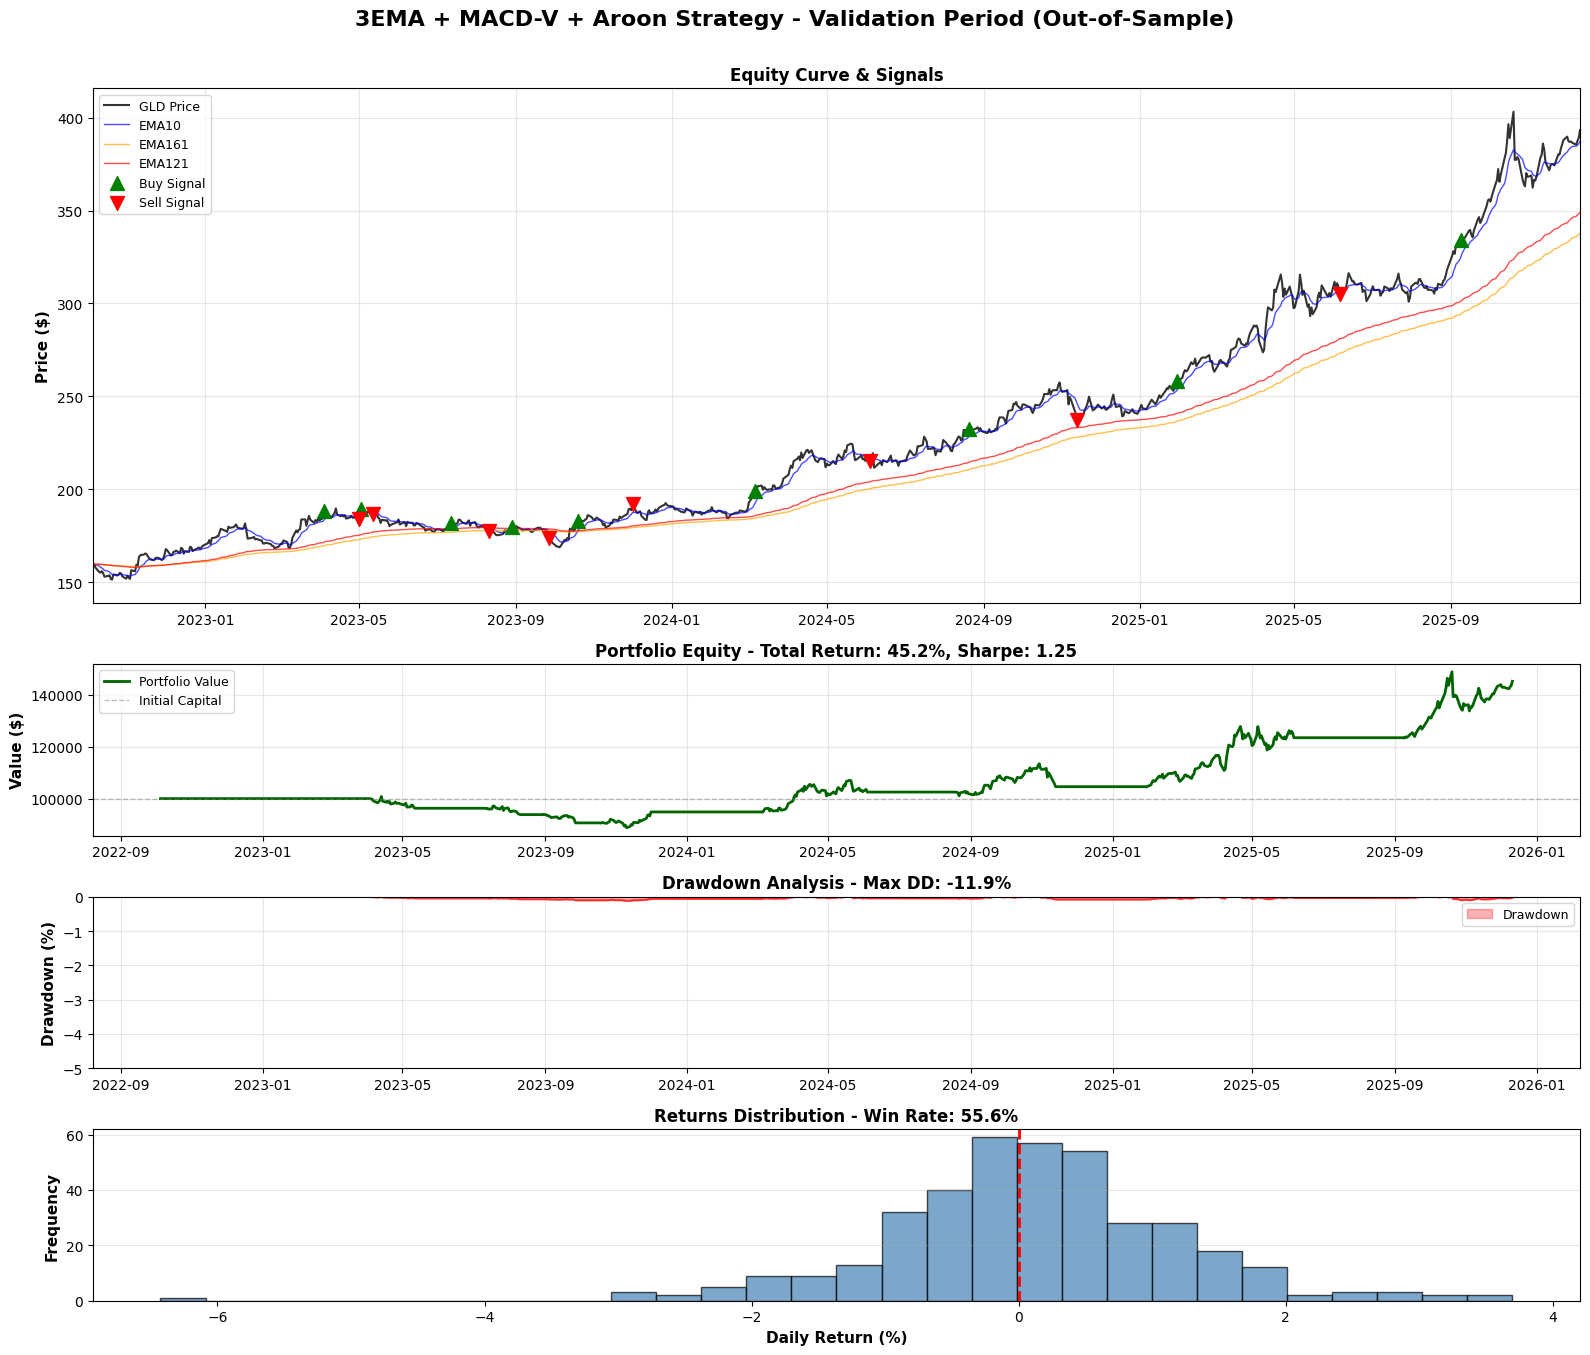

✅ Validation period visualization saved!


In [12]:
# CREATE COMPREHENSIVE MULTI-PANEL VISUALIZATION - VALIDATION PERIOD

fig, axes = plt.subplots(4, 1, figsize=(16, 14), height_ratios=[3, 1, 1, 1])
fig.suptitle('3EMA + MACD-V + Aroon Strategy - Validation Period (Out-of-Sample)', 
             fontsize=16, fontweight='bold', y=0.995)

# Plot 1: Price + EMAs + Signals
ax1 = axes[0]
ax1.plot(val_close.index, val_close.values, label=f'{TICKER} Price', 
         color='black', linewidth=1.5, alpha=0.8)

# Calculate EMAs for display
ema1_display = val_close.ewm(span=ema1, adjust=False).mean()
ema2_display = val_close.ewm(span=ema2, adjust=False).mean()
ema3_display = val_close.ewm(span=ema3, adjust=False).mean()

ax1.plot(val_close.index, ema1_display.values, label=f'EMA{ema1}', 
         color='blue', linewidth=1, alpha=0.7)
ax1.plot(val_close.index, ema2_display.values, label=f'EMA{ema2}', 
         color='orange', linewidth=1, alpha=0.7)
ax1.plot(val_close.index, ema3_display.values, label=f'EMA{ema3}', 
         color='red', linewidth=1, alpha=0.7)

# Plot entry/exit signals
try:
    orders_df = val_portfolio.orders.records_readable
    entries = orders_df[orders_df['Side'] == 'Buy']
    exits = orders_df[orders_df['Side'] == 'Sell']
    
    if len(entries) > 0:
        # Try different possible column names
        price_col = 'Price' if 'Price' in entries.columns else 'Amount' if 'Amount' in entries.columns else 'Value'
        time_col = 'Index' if 'Index' in entries.columns else 'Timestamp'
        
        if price_col in entries.columns and time_col in entries.columns:
            ax1.scatter(entries[time_col], entries[price_col], color='green', 
                        marker='^', s=100, label='Buy Signal', zorder=5)
    if len(exits) > 0:
        price_col = 'Price' if 'Price' in exits.columns else 'Amount' if 'Amount' in exits.columns else 'Value'
        time_col = 'Index' if 'Index' in exits.columns else 'Timestamp'
        
        if price_col in exits.columns and time_col in exits.columns:
            ax1.scatter(exits[time_col], exits[price_col], color='red', 
                        marker='v', s=100, label='Sell Signal', zorder=5)
except Exception as e:
    print(f"Could not plot signals: {e}")
    # Plot signals using trades data instead
    trades = val_portfolio.trades.records_readable
    buy_times = []
    sell_times = []
    buy_prices = []
    sell_prices = []
    
    for _, trade in trades.iterrows():
        if trade['EntryTimestamp']:
            buy_times.append(trade['EntryTimestamp'])
            buy_prices.append(trade['EntryPrice'])
        if trade['ExitTimestamp']:
            sell_times.append(trade['ExitTimestamp'])
            sell_prices.append(trade['ExitPrice'])
    
    if buy_times:
        ax1.scatter(buy_times, buy_prices, color='green', marker='^', s=100, label='Buy Signal', zorder=5)
    if sell_times:
        ax1.scatter(sell_times, sell_prices, color='red', marker='v', s=100, label='Sell Signal', zorder=5)

ax1.set_ylabel('Price ($)', fontsize=11, fontweight='bold')
ax1.set_title(f'Equity Curve & Signals', fontsize=12, fontweight='bold')
ax1.legend(loc='best', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(val_close.index[0], val_close.index[-1])

# Plot 2: Portfolio Value
ax2 = axes[1]
portfolio_value = val_portfolio.value()
ax2.plot(val_close.index, portfolio_value, label='Portfolio Value', 
         color='darkgreen', linewidth=2)
ax2.axhline(y=100000, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Initial Capital')
ax2.set_ylabel('Value ($)', fontsize=11, fontweight='bold')
ax2.set_title(f'Portfolio Equity - Total Return: {val_result["total_return"]:.1%}, '
               f'Sharpe: {val_result["sharpe_ratio"]:.2f}', fontsize=12, fontweight='bold')
ax2.legend(loc='best', fontsize=9)
ax2.grid(True, alpha=0.3)

# Plot 3: Drawdown
ax3 = axes[2]
drawdown = val_portfolio.drawdown()
ax3.fill_between(val_close.index, drawdown.values, 0, 
                  color='red', alpha=0.3, label='Drawdown')
ax3.plot(val_close.index, drawdown.values, color='red', linewidth=1.5, alpha=0.7)
ax3.set_ylabel('Drawdown (%)', fontsize=11, fontweight='bold')
ax3.set_title(f'Drawdown Analysis - Max DD: {val_result["max_drawdown"]:.1%}', 
              fontsize=12, fontweight='bold')
ax3.legend(loc='best', fontsize=9)
ax3.grid(True, alpha=0.3)
ax3.set_ylim(bottom=-max(abs(drawdown.min()), 5))

# Plot 4: Returns Distribution
ax4 = axes[3]
returns = val_portfolio.returns()
non_zero_returns = returns[returns != 0]
if len(non_zero_returns) > 0:
    ax4.hist(non_zero_returns * 100, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    ax4.axvline(0, color='red', linestyle='--', linewidth=2)
ax4.set_xlabel('Daily Return (%)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax4.set_title(f'Returns Distribution - Win Rate: {val_result["win_rate"]:.1f}%', 
              fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.savefig('3EMA_MACDV_Aroon_Validation_Comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Validation period visualization saved!")


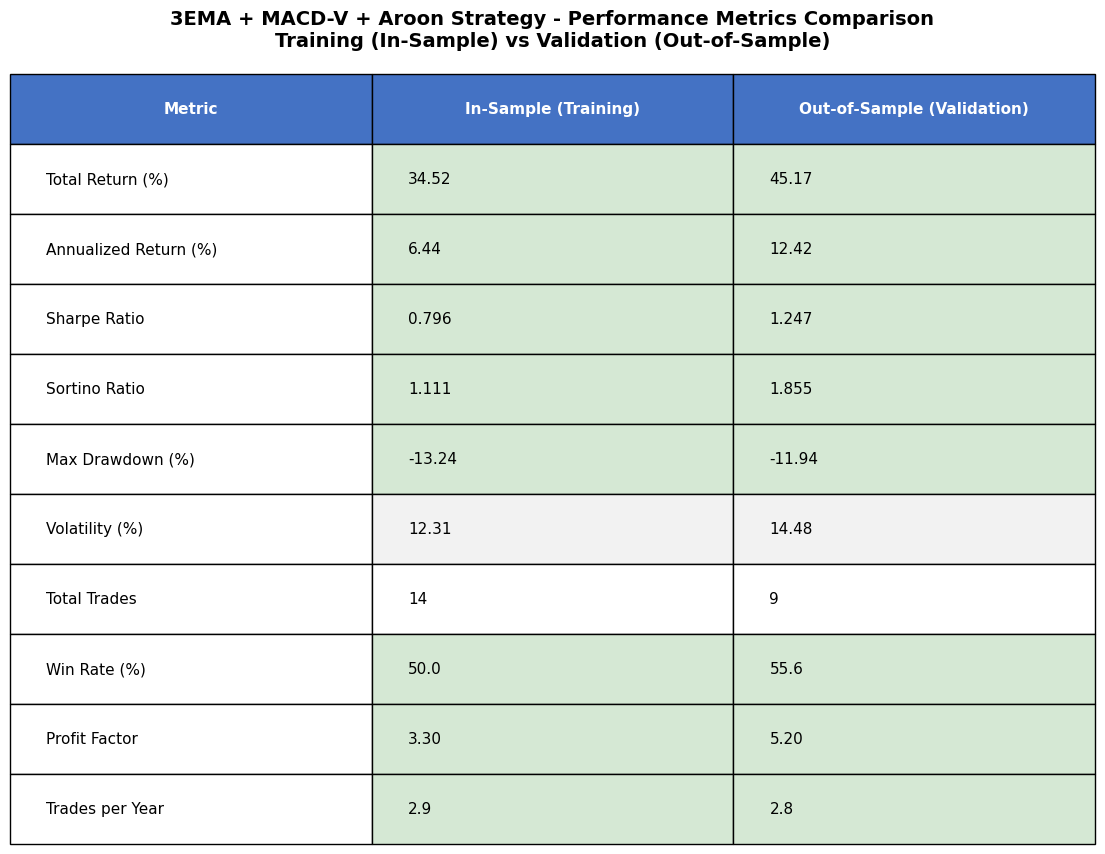

✅ Metrics comparison table saved!

VISUALIZATION SUMMARY
1. Training period comprehensive analysis saved
2. Validation period comprehensive analysis saved
3. Metrics comparison table saved


In [13]:
# CREATE METRICS COMPARISON TABLE VISUALIZATION

# Prepare data for comparison
metrics_data = {
    'Metric': [
        'Total Return (%)',
        'Annualized Return (%)',
        'Sharpe Ratio',
        'Sortino Ratio',
        'Max Drawdown (%)',
        'Volatility (%)',
        'Total Trades',
        'Win Rate (%)',
        'Profit Factor',
        'Trades per Year'
    ],
    'In-Sample (Training)': [
        f"{train_result['total_return']*100:.2f}",
        f"{train_result['annualized_return']*100:.2f}",
        f"{train_result['sharpe_ratio']:.3f}",
        f"{train_result['sortino_ratio']:.3f}",
        f"{train_result['max_drawdown']*100:.2f}",
        f"{train_result['volatility']*100:.2f}",
        f"{int(train_result['total_trades'])}",
        f"{train_result['win_rate']:.1f}",
        f"{train_result['profit_factor']:.2f}",
        f"{train_result['trades_per_year']:.1f}"
    ],
    'Out-of-Sample (Validation)': [
        f"{val_result['total_return']*100:.2f}",
        f"{val_result['annualized_return']*100:.2f}",
        f"{val_result['sharpe_ratio']:.3f}",
        f"{val_result['sortino_ratio']:.3f}",
        f"{val_result['max_drawdown']*100:.2f}",
        f"{val_result['volatility']*100:.2f}",
        f"{int(val_result['total_trades'])}",
        f"{val_result['win_rate']:.1f}",
        f"{val_result['profit_factor']:.2f}",
        f"{val_result['trades_per_year']:.1f}"
    ]
}

# Create comparison DataFrame
comparison_df = pd.DataFrame(metrics_data)

# Create visualization
fig, ax = plt.subplots(figsize=(14, 10))
ax.axis('tight')
ax.axis('off')

# Create table
table = ax.table(cellText=comparison_df.values, 
                 colLabels=comparison_df.columns,
                 cellLoc='left',
                 loc='center',
                 bbox=[0, 0, 1, 1])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Color headers
for i in range(len(comparison_df.columns)):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Color coding based on performance
for i in range(1, len(comparison_df) + 1):
    metric = comparison_df.iloc[i-1]['Metric']
    
    # Green for good metrics (higher is better)
    if any(x in metric.lower() for x in ['return', 'sharpe', 'sortino', 'win rate', 'profit', 'trades']):
        try:
            val_train = float(comparison_df.iloc[i-1]['In-Sample (Training)'].replace('%', ''))
            val_test = float(comparison_df.iloc[i-1]['Out-of-Sample (Validation)'].replace('%', ''))
            
            if val_test >= val_train * 0.9:  # Within 10% of training
                for j in [1, 2]:
                    table[(i, j)].set_facecolor('#D5E8D4')  # Light green
            elif val_test >= val_train * 0.7:  # Within 30% of training
                table[(i, 2)].set_facecolor('#FFF4CC')  # Light yellow
        except:
            pass
    # Red for bad metrics (higher is worse - drawdown)
    elif 'drawdown' in metric.lower():
        try:
            val_train = float(comparison_df.iloc[i-1]['In-Sample (Training)'].replace('%', ''))
            val_test = float(comparison_df.iloc[i-1]['Out-of-Sample (Validation)'].replace('%', ''))
            
            if abs(val_test) <= abs(val_train) * 1.1:  # Similar or better
                for j in [1, 2]:
                    table[(i, j)].set_facecolor('#D5E8D4')  # Light green
            else:
                table[(i, 2)].set_facecolor('#F8CECC')  # Light red
        except:
            pass
    else:
        # Neutral background for other metrics
        for j in [1, 2]:
            table[(i, j)].set_facecolor('#F2F2F2')

plt.title('3EMA + MACD-V + Aroon Strategy - Performance Metrics Comparison\n' +
          'Training (In-Sample) vs Validation (Out-of-Sample)',
          fontsize=14, fontweight='bold', pad=20)

plt.savefig('3EMA_MACDV_Aroon_Metrics_Table.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Metrics comparison table saved!")
print("\n" + "=" * 70)
print("VISUALIZATION SUMMARY")
print("=" * 70)
print("1. Training period comprehensive analysis saved")
print("2. Validation period comprehensive analysis saved")  
print("3. Metrics comparison table saved")
print("=" * 70)


In [14]:
# FULL SAMPLE ANALYSIS - Complete Dataset Performance

print("=" * 70)
print("FULL SAMPLE ANALYSIS - Complete Dataset Evaluation")
print("=" * 70)
print(f"Analyzing entire dataset: {close.index[0].date()} to {close.index[-1].date()}")
print(f"Total Duration: {len(close)} days (~{len(close)/252:.1f} years)")
print("=" * 70)

# Evaluate strategy on full dataset
full_result = evaluate_ensemble_strategy(
    data=close,
    stock_data_for_volume=stock_data,
    return_metrics=True
)

# Get full portfolio
full_portfolio = get_ensemble_portfolio(close, stock_data)

print("\n" + "=" * 70)
print("FULL SAMPLE PERFORMANCE METRICS")
print("=" * 70)
print(f"Total Return:           {full_result['total_return']:.2%}")
print(f"Annualized Return:      {full_result['annualized_return']:.2%}")
print(f"Sharpe Ratio:           {full_result['sharpe_ratio']:.3f}")
print(f"Sortino Ratio:          {full_result['sortino_ratio']:.3f}")
print(f"Max Drawdown:           {full_result['max_drawdown']:.2%}")
print(f"Volatility:             {full_result['volatility']:.2%}")
print(f"Total Trades:           {int(full_result['total_trades'])}")
print(f"Win Rate:               {full_result['win_rate']:.1f}%")
print(f"Profit Factor:          {full_result['profit_factor']:.2f}")
print(f"Expectancy:             {full_result['expectancy']:.4f}")
print(f"Trades per Year:        {full_result['trades_per_year']:.1f}")
print("=" * 70)

# Get trade analysis
trades = full_portfolio.trades.records_readable

if len(trades) > 0:
    print("\n" + "=" * 70)
    print("DETAILED TRADE ANALYSIS")
    print("=" * 70)
    
    # Calculate trade statistics
    trade_returns = []
    winning_trades = []
    losing_trades = []
    
    for _, trade in trades.iterrows():
        pnl = trade.get('PnL', 0) if 'PnL' in trade else trade.get('Return', 0)
        if isinstance(pnl, (int, float)):
            trade_returns.append(pnl)
            if pnl > 0:
                winning_trades.append(pnl)
            elif pnl < 0:
                losing_trades.append(pnl)
    
    if winning_trades:
        avg_win = np.mean(winning_trades)
        max_win = np.max(winning_trades)
        print(f"\nWinning Trades: {len(winning_trades)}")
        print(f"  Average Win:     {avg_win:.2%}")
        print(f"  Largest Win:     {max_win:.2%}")
        print(f"  Total Wins:      {sum(winning_trades):.2%}")
    
    if losing_trades:
        avg_loss = np.mean(losing_trades)
        max_loss = np.min(losing_trades)
        print(f"\nLosing Trades: {len(losing_trades)}")
        print(f"  Average Loss:    {avg_loss:.2%}")
        print(f"  Largest Loss:    {max_loss:.2%}")
        print(f"  Total Losses:    {sum(losing_trades):.2%}")
    
    if winning_trades and losing_trades:
        risk_reward = abs(avg_win / avg_loss) if avg_loss != 0 else 0
        print(f"\nRisk/Reward Ratio: {risk_reward:.2f}")
    
    # Monthly returns analysis
    portfolio_value = full_portfolio.value()
    monthly_returns = portfolio_value.resample('M').last().pct_change().dropna()
    
    print(f"\nMonthly Returns Analysis:")
    print(f"  Best Month:        {monthly_returns.max():.2%}")
    print(f"  Worst Month:       {monthly_returns.min():.2%}")
    print(f"  Average Month:     {monthly_returns.mean():.2%}")
    print(f"  Positive Months:   {(monthly_returns > 0).sum()} / {len(monthly_returns)} ({((monthly_returns > 0).sum()/len(monthly_returns)*100):.1f}%)")
    
    # Yearly returns
    yearly_returns = portfolio_value.resample('Y').last().pct_change().dropna()
    print(f"\nYearly Returns:")
    for year, ret in yearly_returns.items():
        print(f"  {year.year}: {ret:.2%}")
    
    print("=" * 70)

print("\n✅ Full sample analysis complete!")


FULL SAMPLE ANALYSIS - Complete Dataset Evaluation
Analyzing entire dataset: 2018-01-02 to 2025-12-11
Total Duration: 1998 days (~7.9 years)

FULL SAMPLE PERFORMANCE METRICS
Total Return:           116.39%
Annualized Return:      10.21%
Sharpe Ratio:           1.088
Sortino Ratio:          1.587
Max Drawdown:           -13.24%
Volatility:             13.85%
Total Trades:           23
Win Rate:               56.5%
Profit Factor:          5.34
Expectancy:             0.0361
Trades per Year:        2.9

DETAILED TRADE ANALYSIS

Winning Trades: 13
  Average Win:     1093580.09%
  Largest Win:     3238063.39%
  Total Wins:      14216541.16%

Losing Trades: 10
  Average Loss:    -257803.93%
  Largest Loss:    -638318.59%
  Total Losses:    -2578039.32%

Risk/Reward Ratio: 4.24

Monthly Returns Analysis:
  Best Month:        11.18%
  Worst Month:       -6.36%
  Average Month:     0.86%
  Positive Months:   39 / 95 (41.1%)

Yearly Returns:
  2019: 17.60%
  2020: 7.41%
  2021: 1.89%
  2022: 3.7

C:\Users\harka\AppData\Local\Temp\ipykernel_3380\262081977.py:80: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

C:\Users\harka\AppData\Local\Temp\ipykernel_3380\262081977.py:89: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



C:\Users\harka\AppData\Local\Temp\ipykernel_3380\2377400073.py:103: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



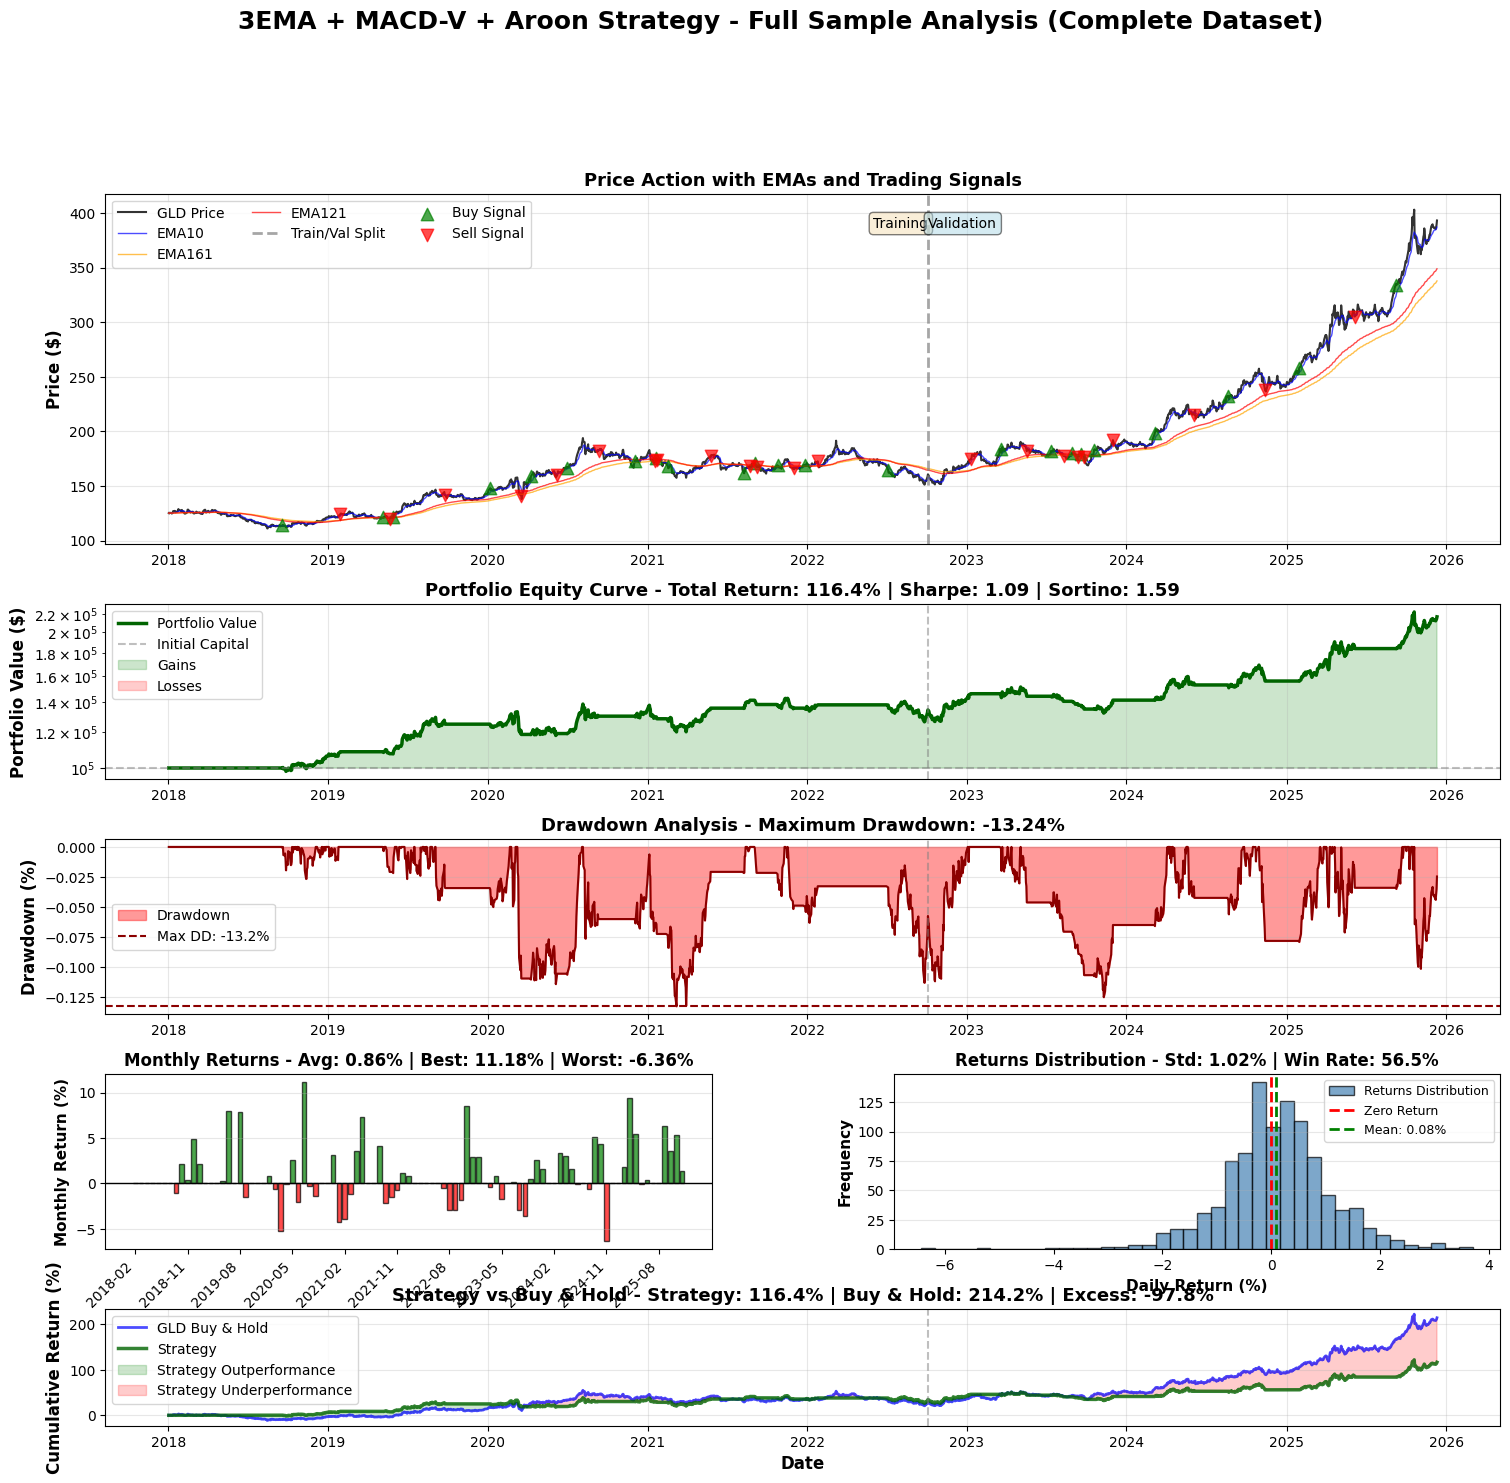


✅ Full sample comprehensive visualization saved!
File: 3EMA_MACDV_Aroon_Full_Sample_Analysis.png


In [15]:
# FULL SAMPLE COMPREHENSIVE VISUALIZATION

fig = plt.figure(figsize=(18, 16))
gs = fig.add_gridspec(5, 2, height_ratios=[3, 1.5, 1.5, 1.5, 1], hspace=0.3, wspace=0.3)
fig.suptitle('3EMA + MACD-V + Aroon Strategy - Full Sample Analysis (Complete Dataset)', 
             fontsize=18, fontweight='bold', y=0.995)

# ===== PLOT 1: Price + EMAs + Signals =====
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(close.index, close.values, label=f'{TICKER} Price', 
         color='black', linewidth=1.5, alpha=0.8)

# Calculate EMAs for display
ema1_display = close.ewm(span=ema1, adjust=False).mean()
ema2_display = close.ewm(span=ema2, adjust=False).mean()
ema3_display = close.ewm(span=ema3, adjust=False).mean()

ax1.plot(close.index, ema1_display.values, label=f'EMA{ema1}', 
         color='blue', linewidth=1, alpha=0.7)
ax1.plot(close.index, ema2_display.values, label=f'EMA{ema2}', 
         color='orange', linewidth=1, alpha=0.7)
ax1.plot(close.index, ema3_display.values, label=f'EMA{ema3}', 
         color='red', linewidth=1, alpha=0.7)

# Add split line
ax1.axvline(x=close.index[split_idx], color='gray', linestyle='--', 
            linewidth=2, alpha=0.7, label='Train/Val Split')
ax1.text(close.index[split_idx], ax1.get_ylim()[1]*0.95, 'Training', 
         ha='right', va='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax1.text(close.index[split_idx], ax1.get_ylim()[1]*0.95, 'Validation', 
         ha='left', va='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

# Plot signals
try:
    orders_df = full_portfolio.orders.records_readable
    entries = orders_df[orders_df['Side'] == 'Buy']
    exits = orders_df[orders_df['Side'] == 'Sell']
    
    if len(entries) > 0:
        price_col = 'Price' if 'Price' in entries.columns else 'Amount' if 'Amount' in entries.columns else 'Value'
        however_col = 'Index' if 'Index' in entries.columns else 'Timestamp'
        if price_col in entries.columns and however_col in entries.columns:
            ax1.scatter(entries[however_col], entries[price_col], color='green', 
                        marker='^', s=80, label='Buy Signal', zorder=5, alpha=0.7)
    if len(exits) > 0:
        price_col = 'Price' if 'Price' in exits.columns else 'Amount' if 'Amount' in exits.columns else 'Value'
        however_col = 'Index' if 'Index' in exits.columns else 'Timestamp'
        if price_col in exits.columns and however_col in exits.columns:
            ax1.scatter(exits[however_col], exits[price_col], color='red', 
                        marker='v', s=80, label='Sell Signal', zorder=5, alpha=0.7)
except:
    pass

ax1.set_ylabel('Price ($)', fontsize=12, fontweight='bold')
ax1.set_title(f'Price Action with EMAs and Trading Signals', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=10, ncol=3)
ax1.grid(True, alpha=0.3)

# ===== PLOT 2: Portfolio Equity Curve =====
ax2 = fig.add_subplot(gs[1, :])
portfolio_value = full_portfolio.value()
ax2.plot(close.index, portfolio_value, label='Portfolio Value', 
         color='darkgreen', linewidth=2.5)
ax2.axhline(y=100000, color='gray', linestyle='--', linewidth=1.5, 
            alpha=0.5, label='Initial Capital')
ax2.axvline(x=close.index[split_idx], color='gray', linestyle='--', 
            linewidth=1.5, alpha=0.5)
ax2.fill_between(close.index, 100000, portfolio_value.values, 
                  where=(portfolio_value.values >= 100000), 
                  alpha=0.2, color='green', label='Gains')
ax2.fill_between(close.index, portfolio_value.values, 100000, 
                  where=(portfolio_value.values < 100000), 
                  alpha=0.2, color='red', label='Losses')
ax2.set_ylabel('Portfolio Value ($)', fontsize=12, fontweight='bold')
ax2.set_title(f'Portfolio Equity Curve - Total Return: {full_result["total_return"]:.1%} | '
               f'Sharpe: {full_result["sharpe_ratio"]:.2f} | '
               f'Sortino: {full_result["sortino_ratio"]:.2f}', 
               fontsize=13, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')  # Log scale for better visualization

# ===== PLOT 3: Drawdown =====
ax3 = fig.add_subplot(gs[2, :])
drawdown = full_portfolio.drawdown()
ax3.fill_between(close.index, drawdown.values, 0, 
                  color='red', alpha=0.4, label='Drawdown')
ax3.plot(close.index, drawdown.values, color='darkred', linewidth=1.5)
ax3.axvline(x=close.index[split_idx], color='gray', linestyle='--', 
            linewidth=1.5, alpha=0.5)
ax3.axhline(y=full_result['max_drawdown'], color='darkred', 
            linestyle='--', linewidth=1.5, 
            label=f"Max DD: {full_result['max_drawdown']:.1%}")
ax3.set_ylabel('Drawdown (%)', fontsize=12, fontweight='bold')
ax3.set_title(f'Drawdown Analysis - Maximum Drawdown: {full_result["max_drawdown"]:.2%}', 
              fontsize=13, fontweight='bold')
ax3.legend(loc='best', fontsize=10)
ax3.grid(True, alpha=0.3)

# ===== PLOT 4: Monthly Returns =====
ax4 = fig.add_subplot(gs[3, 0])
portfolio_value = full_portfolio.value()
monthly_returns = portfolio_value.resample('M').last().pct_change().dropna() * 100

colors = ['green' if x > 0 else 'red' for x in monthly_returns.values]
ax4.bar(range(len(monthly_returns)), monthly_returns.values, color=colors, alpha=0.7, edgecolor='black')
ax4.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax4.set_xlabel('Month', fontsize=11, fontweight='bold')
ax4.set_ylabel('Monthly Return (%)', fontsize=11, fontweight='bold')
ax4.set_title(f'Monthly Returns - Avg: {monthly_returns.mean():.2f}% | '
               f'Best: {monthly_returns.max():.2f}% | Worst: {monthly_returns.min():.2f}%', 
               fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Set x-axis labels for better readability (every 6 months)
if len(monthly_returns) > 0:
    step = max(1, len(monthly_returns) // 10)
    ax4.set_xticks(range(0, len(monthly_returns), step))
    ax4.set_xticklabels([monthly_returns.index[i].strftime('%Y-%m') 
                         for i in range(0, len(monthly_returns), step)], 
                        rotation=45, ha='right')

# ===== PLOT 5: Returns Distribution =====
ax5 = fig.add_subplot(gs[3, 1])
returns = full_portfolio.returns()
non_zero_returns = returns[returns != 0] * 100
if len(non_zero_returns) > 0:
    ax5.hist(non_zero_returns, bins=40, color='steelblue', alpha=0.7, 
             edgecolor='black', label='Returns Distribution')
    ax5.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Return')
    ax5.axvline(non_zero_returns.mean(), color='green', linestyle='--', 
                linewidth=2, label=f'Mean: {non_zero_returns.mean():.2f}%')
    ax5.set_xlabel('Daily Return (%)', fontsize=11, fontweight='bold')
    ax5.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax5.set_title(f'Returns Distribution - Std: {non_zero_returns.std():.2f}% | '
                   f'Win Rate: {full_result["win_rate"]:.1f}%', 
                   fontsize=12, fontweight='bold')
    ax5.legend(loc='best', fontsize=9)
    ax5.grid(True, alpha=0.3, axis='y')

# ===== PLOT 6: Cumulative Returns Comparison =====
ax6 = fig.add_subplot(gs[4, :])
buy_hold_returns = (close / close.iloc[0] - 1) * 100
strategy_returns = (portfolio_value / portfolio_value.iloc[0] - 1) * 100

ax6.plot(close.index, buy_hold_returns.values, label=f'{TICKER} Buy & Hold', 
         color='blue', linewidth=2, alpha=0.7)
ax6.plot(close.index, strategy_returns.values, label='Strategy', 
         color='darkgreen', linewidth=2.5, alpha=0.8)
ax6.axvline(x=close.index[split_idx], color='gray', linestyle='--', 
            linewidth=1.5, alpha=0.5)
ax6.fill_between(close.index, buy_hold_returns.values, strategy_returns.values, 
                  where=(strategy_returns.values >= buy_hold_returns.values),
                  alpha=0.2, color='green', label='Strategy Outperformance')
ax6.fill_between(close.index, buy_hold_returns.values, strategy_returns.values, 
                  where=(strategy_returns.values < buy_hold_returns.values),
                  alpha=0.2, color='red', label='Strategy Underperformance')
ax6.set_xlabel('Date', fontsize=12, fontweight='bold')
ax6.set_ylabel('Cumulative Return (%)', fontsize=12, fontweight='bold')
ax6.set_title(f'Strategy vs Buy & Hold - Strategy: {strategy_returns.iloc[-1]:.1f}% | '
               f'Buy & Hold: {buy_hold_returns.iloc[-1]:.1f}% | '
               f'Excess: {strategy_returns.iloc[-1] - buy_hold_returns.iloc[-1]:.1f}%', 
               fontsize=13, fontweight='bold')
ax6.legend(loc='best', fontsize=10)
ax6.grid(True, alpha=0.3)

plt.savefig('3EMA_MACDV_Aroon_Full_Sample_Analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Full sample comprehensive visualization saved!")
print("File: 3EMA_MACDV_Aroon_Full_Sample_Analysis.png")


In [16]:
# INDICATOR BREAKDOWN ANALYSIS - Which indicators trigger signals?

print("=" * 70)
print("INDICATOR SIGNAL BREAKDOWN ANALYSIS")
print("=" * 70)

# Calculate individual indicator signals
ema1_ma = vbt.MA.run(close, ema1, ewm=True).ma
ema2_ma = vbt.MA.run(close, ema2, ewm=True).ma
ema3_ma = vbt.MA.run(close, ema3, ewm=True).ma

# 3EMA Signals
entries_3ema = (
    ema1_ma.vbt.crossed_above(ema2_ma) |
    ema1_ma.vbt.crossed_above(ema3_ma) |
    ema2_ma.vbt.crossed_above(ema3_ma)
)
exits_3ema = (
    ema1_ma.vbt.crossed_below(ema2_ma) |
    ema1_ma.vbt.crossed_below(ema3_ma) |
    ema2_ma.vbt.crossed_below(ema3_ma)
)

# MACD-V Signals
close_array = close.values
macd, macd_signal_line, _ = talib.MACD(close_array, fastperiod=macd_fast, slowperiod=macd_slow, signalperiod=macd_signal)
macd_series = pd.Series(macd, index=close.index)
signal_series = pd.Series(macd_signal_line, index=close.index)

if isinstance(stock_data.columns, pd.MultiIndex):
    volume_data = stock_data[('Volume', TICKER)]
else:
    volume_data = stock_data['Volume']

volume_aligned = volume_data.reindex(close.index)
volume_sma = volume_aligned.rolling(window=20).mean()
volume_ratio = volume_aligned / volume_sma

macd_bullish_cross = (macd_series > signal_series) & (macd_series.shift(1) <= signal_series.shift(1))
volume_confirm = volume_ratio > volume_threshold
entries_macdv = pd.Series(macd_bullish_cross & volume_confirm, index=close.index).fillna(False)

macd_bearish_cross = (macd_series < signal_series) & (macd_series.shift(1) >= signal_series.shift(1))
exits_macdv = pd.Series(macd_bearish_cross & volume_confirm, index=close.index).fillna(False)

# Aroon Signals
aroon_up, aroon_down = talib.AROON(close_array, close_array, timeperiod=aroon_length)
aroon_up_series = pd.Series(aroon_up, index=close.index)
aroon_down_series = pd.Series(aroon_down, index=close.index)

entries_aroon = aroon_up_series.vbt.crossed_above(aroon_down_series)
exits_aroon = aroon_up_series.vbt.crossed_below(aroon_down_series)

# Final combined signals
entries_final = entries_3ema | entries_macdv | entries_aroon
exits_final = exits_3ema | exits_macdv | exits_aroon

# Count signals
print(f"\nENTRY SIGNALS:")
print(f"  3EMA Signals:     {entries_3ema.sum():4d} ({entries_3ema.sum()/len(entries_3ema)*100:5.1f}% of days)")
print(f"  MACD-V Signals:   {entries_macdv.sum():4d} ({entries_macdv.sum()/len(entries_macdv)*100:5.1f}% of days)")
print(f"  Aroon Signals:    {entries_aroon.sum():4d} ({entries_aroon.sum()/len(entries_aroon)*100:5.1f}% of days)")
print(f"  Combined (OR):    {entries_final.sum():4d} ({entries_final.sum()/len(entries_final)*100:5.1f}% of days)")

print(f"\nEXIT SIGNALS:")
print(f"  3EMA Signals:     {exits_3ema.sum():4d} ({exits_3ema.sum()/len(exits_3ema)*100:5.1f}% of days)")
print(f"  MACD-V Signals:   {exits_macdv.sum():4d} ({exits_macdv.sum()/len(exits_macdv)*100:5.1f}% of days)")
print(f"  Aroon Signals:    {exits_aroon.sum():4d} ({exits_aroon.sum()/len(exits_aroon)*100:5.1f}% of days)")
print(f"  Combined (OR):    {exits_final.sum():4d} ({exits_final.sum()/len(exits_final)*100:5.1f}% of days)")

# Signal overlap analysis
print(f"\nSIGNAL OVERLAP ANALYSIS (Entry Signals):")
only_3ema = (entries_3ema & ~entries_macdv & ~entries_aroon).sum()
only_macdv = (entries_macdv & ~entries_3ema & ~entries_aroon).sum()
only_aroon = (entries_aroon & ~entries_3ema & ~entries_macdv).sum()
ema_macdv = (entries_3ema & entries_macdv & ~entries_aroon).sum()
ema_aroon = (entries_3ema & entries_aroon & ~entries_macdv).sum()
macdv_aroon = (entries_macdv & entries_aroon & ~entries_3ema).sum()
all_three = (entries_3ema & entries_macdv & entries_aroon).sum()

print(f"  Only 3EMA:          {only_3ema:4d}")
print(f"  Only MACD-V:        {only_macdv:4d}")
print(f"  Only Aroon:         {only_aroon:4d}")
print(f"  3EMA + MACD-V:      {ema_macdv:4d}")
print(f"  3EMA + Aroon:       {ema_aroon:4d}")
print(f"  MACD-V + Aroon:     {macdv_aroon:4d}")
print(f"  All Three:          {all_three:4d}")
print(f"  Total Unique:       {only_3ema + only_macdv + only_aroon + ema_macdv + ema_aroon + macdv_aroon + all_three:4d}")

# Calculate contribution percentages
total_entries = entries_final.sum()
if total_entries > 0:
    print(f"\nCONTRIBUTION TO FINAL ENTRY SIGNALS:")
    print(f"  3EMA contributes:    {entries_3ema.sum()/total_entries*100:5.1f}% of all entries")
    print(f"  MACD-V contributes:  {entries_macdv.sum()/total_entries*100:5.1f}% of all entries")
    print(f"  Aroon contributes:   {entries_aroon.sum()/total_entries*100:5.1f}% of all entries")

print("=" * 70)
print("\n✅ Indicator breakdown analysis complete!")


INDICATOR SIGNAL BREAKDOWN ANALYSIS

ENTRY SIGNALS:
  3EMA Signals:       24 (  1.2% of days)
  MACD-V Signals:     15 (  0.8% of days)
  Aroon Signals:       4 (  0.2% of days)
  Combined (OR):      42 (  2.1% of days)

EXIT SIGNALS:
  3EMA Signals:       22 (  1.1% of days)
  MACD-V Signals:     14 (  0.7% of days)
  Aroon Signals:       5 (  0.3% of days)
  Combined (OR):      41 (  2.1% of days)

SIGNAL OVERLAP ANALYSIS (Entry Signals):
  Only 3EMA:            23
  Only MACD-V:          15
  Only Aroon:            3
  3EMA + MACD-V:         0
  3EMA + Aroon:          1
  MACD-V + Aroon:        0
  All Three:             0
  Total Unique:         42

CONTRIBUTION TO FINAL ENTRY SIGNALS:
  3EMA contributes:     57.1% of all entries
  MACD-V contributes:   35.7% of all entries
  Aroon contributes:     9.5% of all entries

✅ Indicator breakdown analysis complete!
